<a href="https://colab.research.google.com/github/AdamVinestock/Advanced-ML/blob/main/(3)_XAI_LIME_on_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable AI using LIME

This notebook will showcase the application of LIME (Local Interpretable Model-Agnostic Explanations) on a ”black box”
image classifying model. Using LIME, we provide local explanations for the top three classes predicted by the model for
three selected images.

In [1]:
import pandas as pd
import numpy as np
import warnings
import tqdm
import random

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import matplotlib.pyplot as plt

from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

from IPython.display import display
from torchvision.io import ImageReadMode, read_image

from sklearn import linear_model

In [2]:
SEED = 42

# Set the random seed for Python to SEED
random.seed(SEED)

# Set the random seed for numpy to SEED
np.random.seed(42)

# Set the random seed for torch to SEED
torch.manual_seed(SEED)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

In [5]:
# Initiating the Model (ResNet-50)
weights = ResNet50_Weights.DEFAULT
category_names = weights.meta["categories"]
model = resnet50(weights=weights)
model.eval()
model.to(device)
transform = weights.transforms(antialias=True)

# Creating the image dataset
image_paths = ['./img1.jpg', 'img2.jpg', 'img3.jpg']

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s]


In [6]:
# Load the images
dataset = [read_image(image_path, mode=ImageReadMode.RGB) for image_path in image_paths]

# Apply transformations to the images
dataset_transformed = [transform(image) for image in dataset]

In [7]:
def convert_image(image_tensor):
    # convert image tensor to np with dimenstions (H,W,C)
    image_array = image_tensor.permute(1, 2, 0).cpu().numpy()
    return image_array

def classify_img(image_tensor, preprocess=None):
    image_tensor = image_tensor.to(device)
    image_tensor = preprocess(image_tensor)
    top3 = []
    # Perform classification on the image tensor
    with torch.no_grad():
        output = model(image_tensor.unsqueeze(0)).cpu()

    # Get the top 3 class values and corresponding indices
    topk_values, topk_indices = torch.topk(output, k=3, dim=1)

    # Convert the tensor values to numpy arrays
    topk_values = topk_values.squeeze().detach().numpy()
    topk_indices = topk_indices.squeeze().detach().numpy()

    # Print the top 3 class values and indices
    for i in range(3):
        class_idx = topk_indices[i]
        class_score = topk_values[i]
        class_name = category_names[class_idx]
        print(f"{class_name} {class_score:.3f}")
        top3.append((class_name,class_score))
    return top3

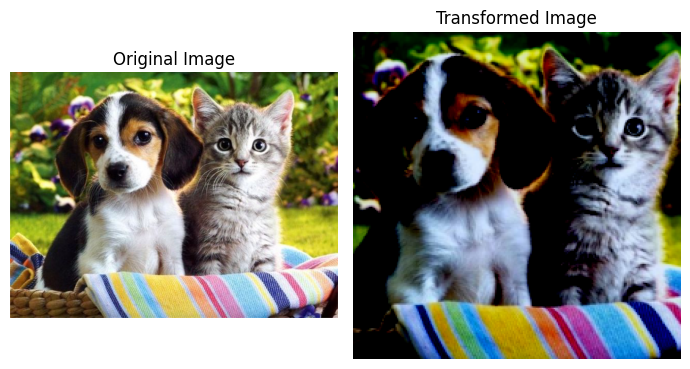

Class scores:
beagle 5.381
English foxhound 3.851
tabby 3.704


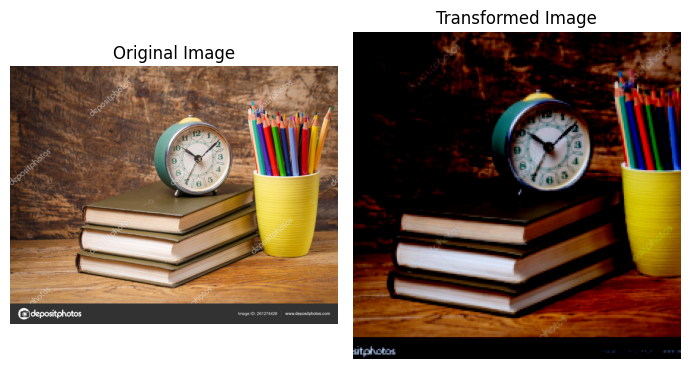

Class scores:
analog clock 5.964
barometer 4.585
pencil box 4.422


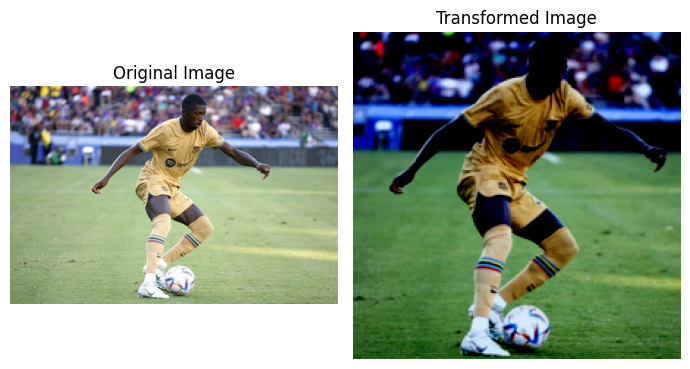

Class scores:
soccer ball 8.578
rugby ball 4.687
knee pad 2.120


In [8]:
scores = []
for image_path, image in zip(image_paths, dataset):
    # Create a new figure for each pair of images
    transformed_image = transform(image)
    fig, axs = plt.subplots(1, 2, figsize=(7, 5))

    # Display the original image
    axs[0].imshow(np.clip(np.asarray(Image.open(image_path)), 0, 255))
    axs[0].axis('off')
    axs[0].set_title("Original Image")

    # Display the transformed image
    transformed_image = convert_image(transformed_image)
    transformed_image = transformed_image/np.amax(transformed_image)
    transformed_image = np.clip(transformed_image, 0, 1)

    axs[1].imshow(transformed_image)
    axs[1].axis('off')
    axs[1].set_title("Transformed Image")

    plt.tight_layout()
    plt.show()

    # Classify the image
    print("Class scores:")
    scores.append(classify_img(image, transform))

In [9]:
def segment_image(img, segments):
  # Input is an image of type tensor (C,H,W), output is segments of shape (H, W) where each value is the lables suerpixel idx
  img = convert_image(img)
  segments = slic(img, n_segments=segments, compactness=10, max_num_iter=30, enforce_connectivity=True, start_label=0)
  return segments

def sample_superPixel(n, p=0.5):
  # Returns a sampled vector of length n: 0 indicating the superpixel should be excluded, 1 indicating it should be included
  values = [0, 1]
  probabilities = [1 - p, p]
  return np.random.choice(values, size=n, p=probabilities)

def mask_sp(image, segments, sampled_sp):
  # Blackens all pixels corresponding to a superpixel that should be excluded
  image = image.copy()
  for segment_label, sp in zip(np.unique(segments), sampled_sp):
      if sp == 0:
          image[segments == segment_label, :] = [128, 128, 128]  # Set pixels to gray
  return image

In [10]:
n_sp = 20  # Number of superpixels
segments = segment_image(dataset[0], n_sp)
sampled_sp = sample_superPixel(n_sp)
img = convert_image(dataset[0])

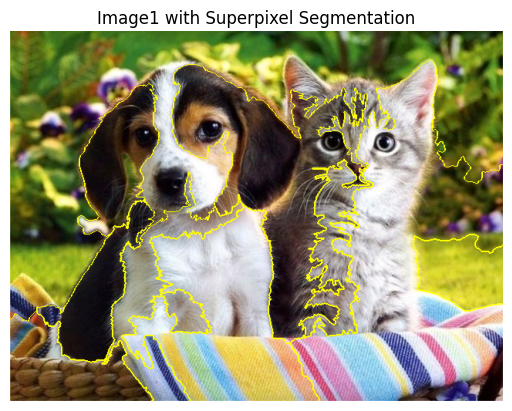

In [11]:
# Display the image with superpixel segmentation
plt.imshow(mark_boundaries(img, segments))
plt.axis('off')
plt.title("Image1 with Superpixel Segmentation")
plt.show()

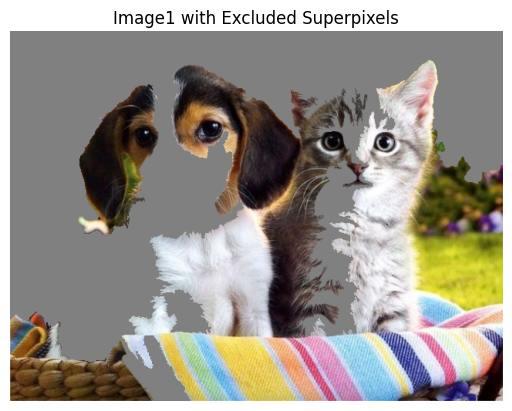

In [12]:
# Display the masked image
image = mask_sp(img, segments, sampled_sp)
plt.imshow(image)
plt.axis('off')
plt.title("Image1 with Excluded Superpixels")
plt.show()

In [13]:
# # Transformed masked image
# transformed_image = torch.tensor(image).clone().detach().permute(2, 1, 0)
# transformed_image = transform(transformed_image)
# transformed_image = np.clip(transformed_image, 0, 1)
# plt.imshow(transformed_image.T)
# plt.show()

In [14]:
def model_predict_score_classification(model, target_class_id, transform, img, weights):
    # Given a tensor image with dimensions (C,H,W) and object class idx, returns the corresponding score
    img = img.permute(2, 1, 0).to(device)
    with torch.no_grad():
        output = model(img.unsqueeze(0).float())
    return output[0][target_class_id].item()

In [15]:
NUM_OF_PERTURBATIONS = 300
SUPERPIXELS_TO_SHUT_DOWN = 10
SIGMA = 10**3

# Creates df for all the images containing the data needed to perform LIME
def _create_df(dataset_transformed, scores, weights, transform, model):
    tracker = []
    image_segments = []
    for image_number, img in enumerate(dataset_transformed):
        img = img.permute(1, 2, 0)
        segments = slic(img, n_segments=n_sp, compactness=10, max_num_iter=30, enforce_connectivity=True, start_label=0)
        image_segments.append(segments)
        for curr_class, curr_score in scores[image_number]:
            target_cls_id = np.where(np.array(weights.meta["categories"]) == curr_class)
            for _ in tqdm.tqdm(range(NUM_OF_PERTURBATIONS)):
                segments_to_shut_down = np.random.choice(
                    range(n_sp), SUPERPIXELS_TO_SHUT_DOWN
                )
                interpretable_instance = np.ones(n_sp)
                interpretable_instance[segments_to_shut_down] = 0
                places_to_shutdown = np.isin(segments, segments_to_shut_down)
                z = img.clone()
                z[places_to_shutdown] = 0
                dist_x_z = torch.dist(img.float(), z.float()).item()
                exp_ker_similarity = np.exp(-1 * (dist_x_z**2) / (SIGMA**2))
                score_with_perturbation = model_predict_score_classification(
                    model, target_cls_id, transform, z, weights
                )
                loss = (exp_ker_similarity * (curr_score - score_with_perturbation) ** 2).item()
                tracker.append(
                    {
                        'image_number': image_number,
                        "class": curr_class,
                        "score": curr_score,
                        "interpretable_instance": interpretable_instance,
                        "exp_ker_similarity": exp_ker_similarity,
                        "score_with_perturbation": score_with_perturbation,
                        "loss": loss,
                    }
                )
    return image_segments, pd.DataFrame(tracker)

In [16]:
image_segments, df = _create_df(dataset_transformed, scores,weights, transform, model)
display(df)

100%|██████████| 300/300 [00:02<00:00, 131.65it/s]


,image_number,class,score,interpretable_instance,exp_ker_similarity,score_with_perturbation,loss
0,0,beagle,5.381340,"[1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",0.925654,1.479648,14.091415
1,0,beagle,5.381340,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, ...",0.850067,6.525858,1.113523
2,0,beagle,5.381340,"[1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...",0.858265,3.946409,1.767190
3,0,beagle,5.381340,"[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, ...",0.878591,6.355082,0.833057
4,0,beagle,5.381340,"[1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",0.916604,6.128656,0.511907
...,...,...,...,...,...,...,...
2695,2,knee pad,2.119688,"[0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, ...",0.903030,1.761696,0.115731
2696,2,knee pad,2.119688,"[1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...",0.903575,2.947223,0.618781
2697,2,knee pad,2.119688,"[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, ...",0.926785,2.793994,0.421399
2698,2,knee pad,2.119688,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...",0.908677,2.256370,0.016976


In [17]:
def get_pos_coef(arr):
    # returns vector of length n_sp, where positive coefficient indices are 1's, the rest are 0's
    pos_idx = np.argwhere(arr>0)
    superpixels = np.zeros(n_sp)
    superpixels[pos_idx] = 1
    return superpixels

def _fit_linear_model(X, y, weights, alpha):
    clf = linear_model.Lasso(alpha)
    clf = clf.fit(
        X,
        y,
        weights,
    )
    return clf

In [18]:
alpha = [0.000001,0.08,0.02] # Per image L1 regularization parameter for LASSO

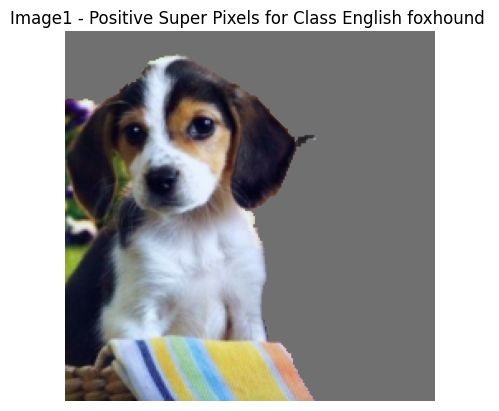

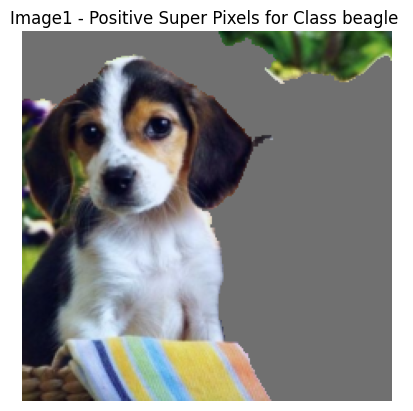

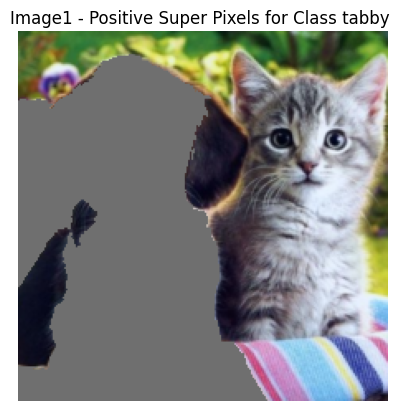

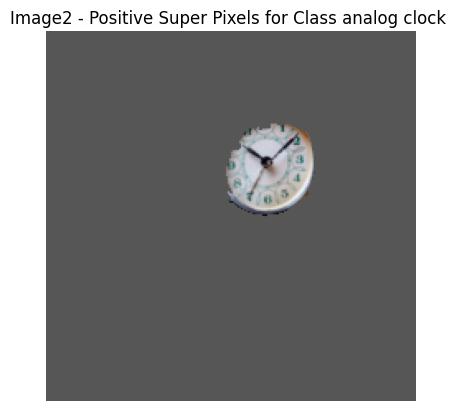

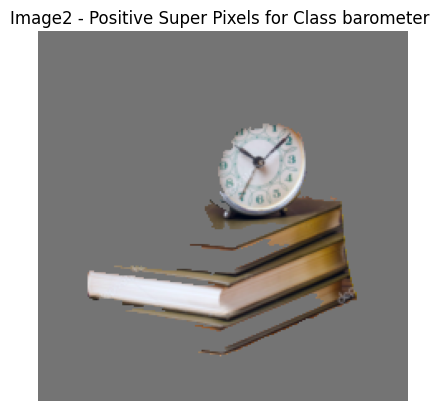

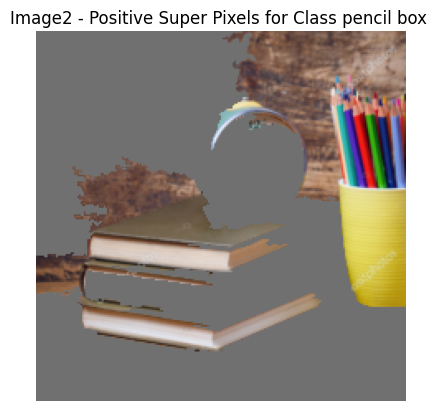

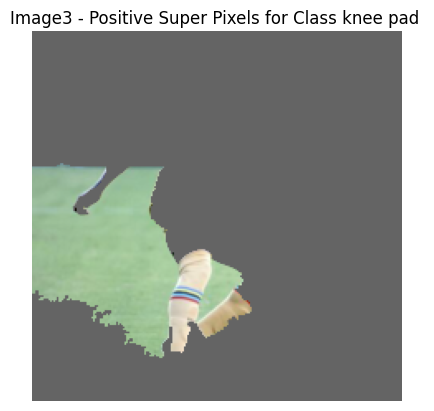

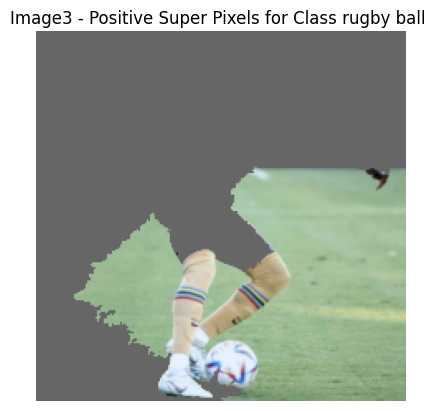

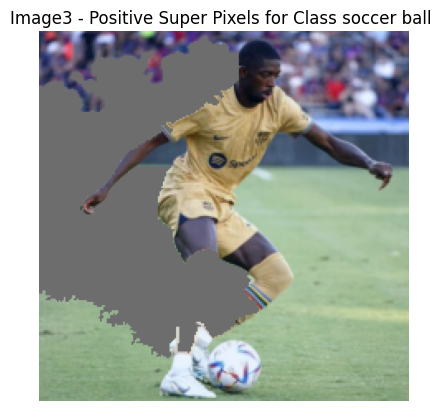

In [19]:
for group_id, group_data in df.groupby(['image_number', 'class']):
    image_number = group_id[0]
    curr_image_tensor = dataset_transformed[image_number].permute(1, 2, 0)

    curr_image_class = group_id[1]
    curr_clf = _fit_linear_model(
        X=group_data["interpretable_instance"].to_list(),
        y=group_data["score_with_perturbation"].to_list(),
        weights=group_data["exp_ker_similarity"].to_list(),
        alpha = alpha[image_number])

    segments = image_segments[image_number]
    img_top_x_superpixels = get_pos_coef(curr_clf.coef_)
    pixels_to_keep = np.isin(segments, np.argwhere(img_top_x_superpixels))

    img_class_super_pixels = curr_image_tensor.clone()
    img_class_super_pixels[~pixels_to_keep] = 0
    img_class_super_pixels = (img_class_super_pixels - img_class_super_pixels.min()) / (img_class_super_pixels.max()-img_class_super_pixels.min())

    # Display the positive superpixels
    plt.imshow(img_class_super_pixels)
    plt.axis("off")
    plt.title(f"Image{image_number+1} - Positive Super Pixels for Class {curr_image_class} ")
    plt.show()